# Figure 1c : identifiy and check selected samples are indeed ultra low and high TF

In [44]:
# Imports

%load_ext autoreload
%autoreload 2

import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

# set working directory
if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

from utils.config import Config
from utils.viz import set_display_params, function_to_split
from utils.util_lift_over import liftover
from lowtfsamples.low_tumor_fraction_samples_identify import plot_patient_timeline, get_mutations_stats
from lowtfsamples.low_tumor_fraction_samples_check import check_pileup

from tqdm.notebook import trange, tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [45]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
set_display_params(config)

paper


In [46]:
# order of samples = 1) high tb sample 1, 2) high tb sample 2, 3) low tb sample
patientsample_dict = {
    '1014': ['NCC_CRC-1014_180816-CW-T', 'NCC_CRC-1014_110116-CW-T', 'NCC_CRC-1014_090516-CW-T'],
    '986': ['NCC_CRC-986_100215-CW-T', 'NCC_CRC-986_261016-CW-T', 'NCC_CRC-986_300316-CW-T'],
    '123': ['NCC_CRC-123_310715-CW-T', 'NCC_CRC-123_070116-CW-T', 'NCC_CRC-123_121115-CW-T']
}


In [47]:
targetbedhg19 = pd.read_csv(os.path.join(*config.extdatafolder, 'Cancer226-targets_hg19.bed'), sep='\t')
targetbedhg38 = pd.read_csv(os.path.join(*config.extdatafolder, 'Cancer226-targets_hg38.bed'), sep='\t')

print(targetbedhg19.shape)
targetbedhg19list = []
for i, r in targetbedhg19.iterrows():
    ra = r[2] +1 - r[1]
    rb = targetbedhg38.iloc[i, 2]+1-targetbedhg38.iloc[i, 1]
    if r[2] <= r[1]:
        raise ValueError('issue with {}'.format(r))
    for p in range(r[1], r[2]+1):
        targetbedhg19list.append('{}_{}'.format(r[0][3:], p))
    if ra != rb:
        print(ra, rb, i)
        for a in range(rb - ra):
            targetbedhg19list.append('{}_{}'.format(r[0][3:], p))
print(len(targetbedhg19list))
print(targetbedhg19list[0])

targetbedhg38list = []
for _, r in targetbedhg38.iterrows():
    for p in range(r[1], r[2]+1):
        targetbedhg38list.append('{}_{}'.format(r[0], p))
print(len(targetbedhg38list))
print(targetbedhg38list[0])

(3879, 6)
785 788 1215
750587
12_46123619
750587
chr12_45729836


# Identify elligibile patients

986
['2015-02-10', '2016-10-26']


<Figure size 640x480 with 0 Axes>

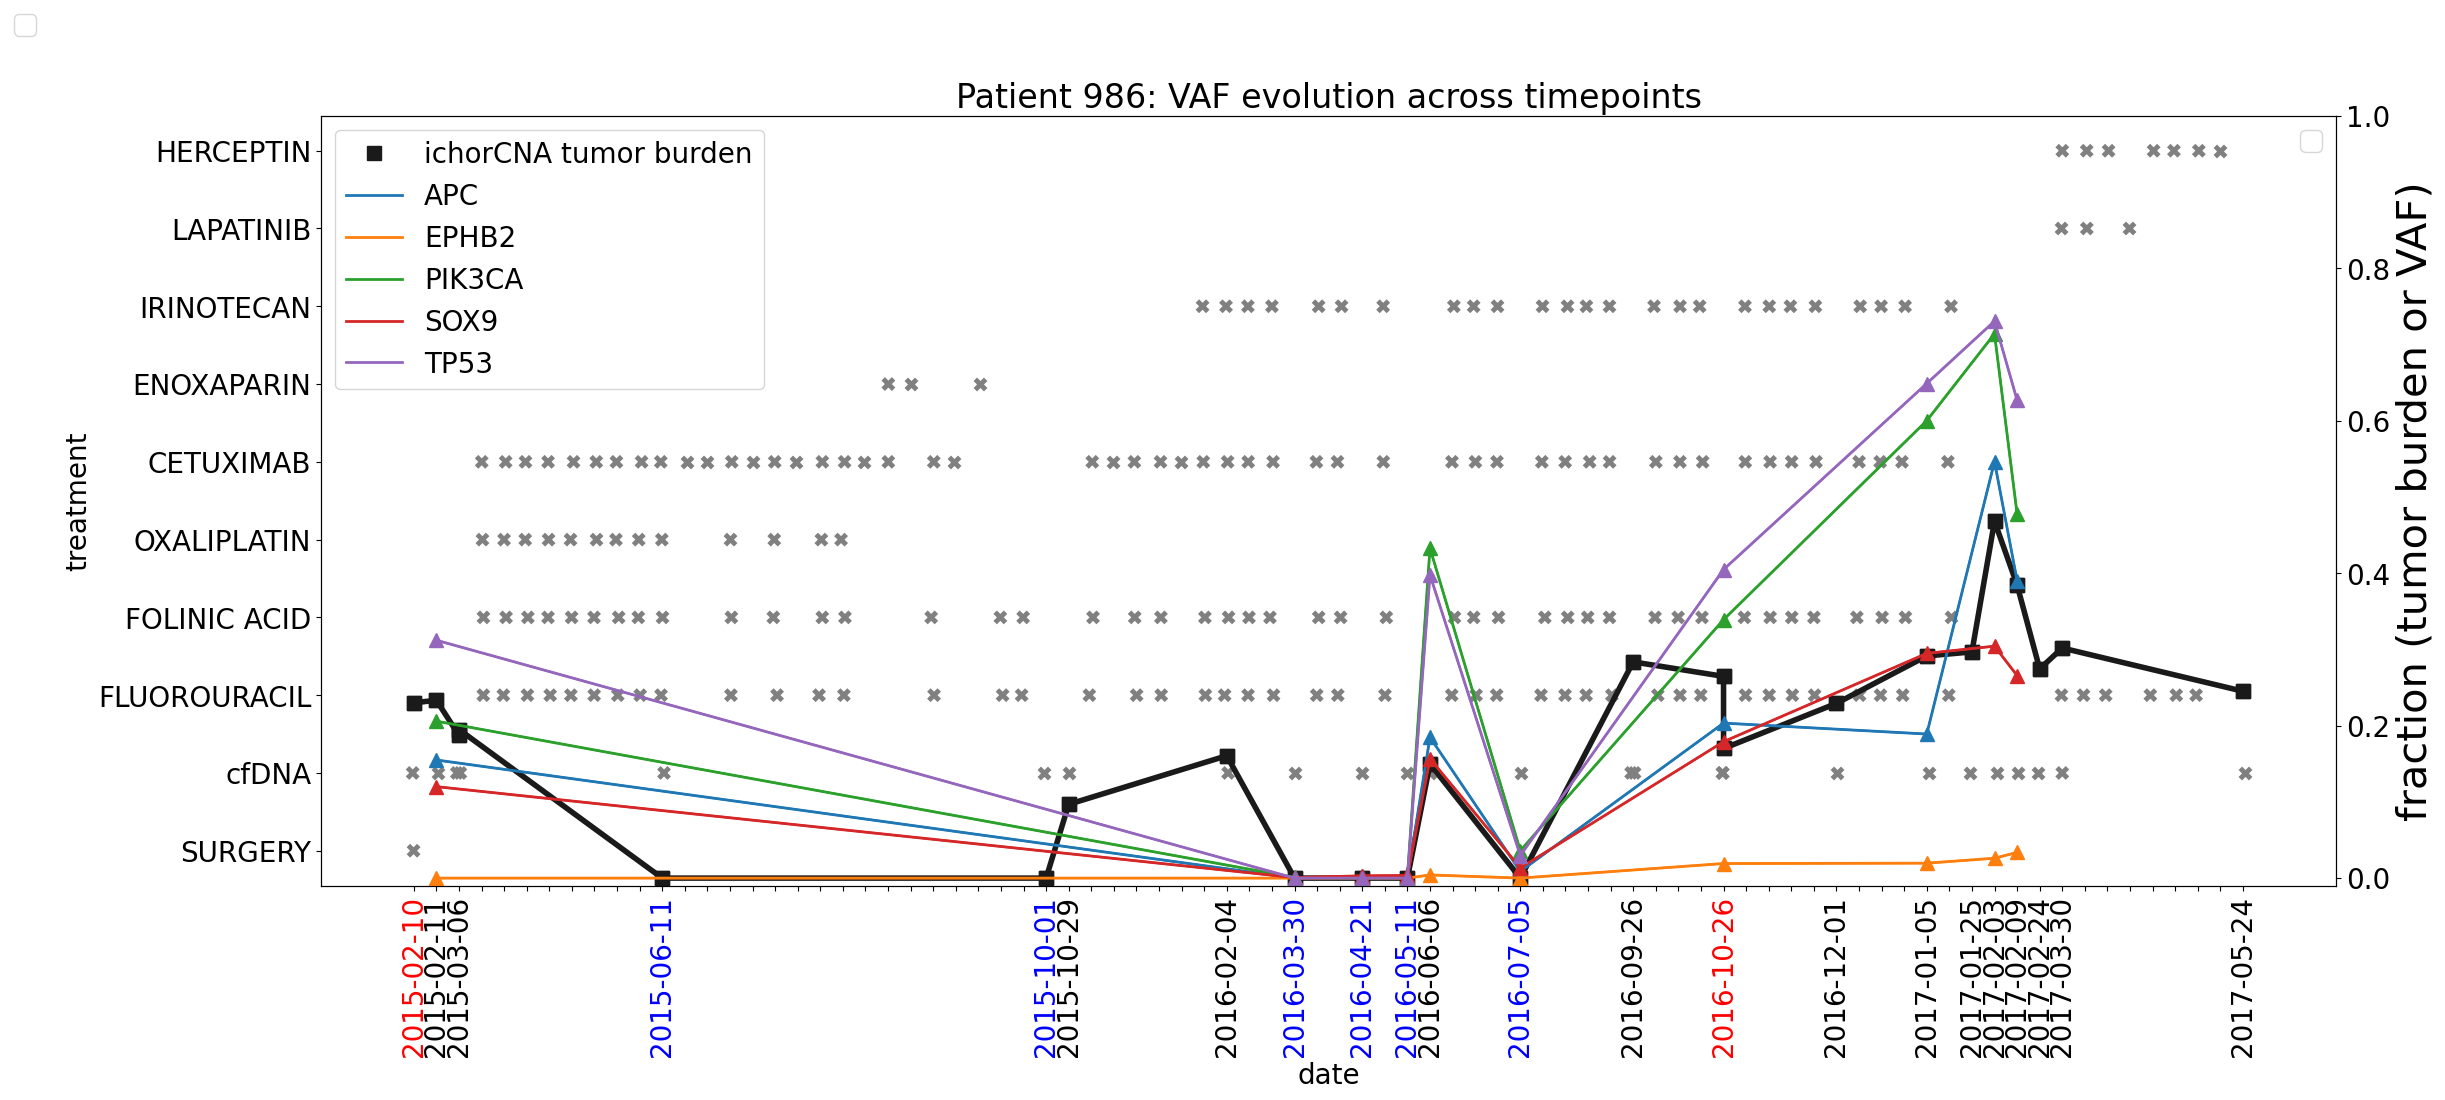

123
[]


<Figure size 640x480 with 0 Axes>

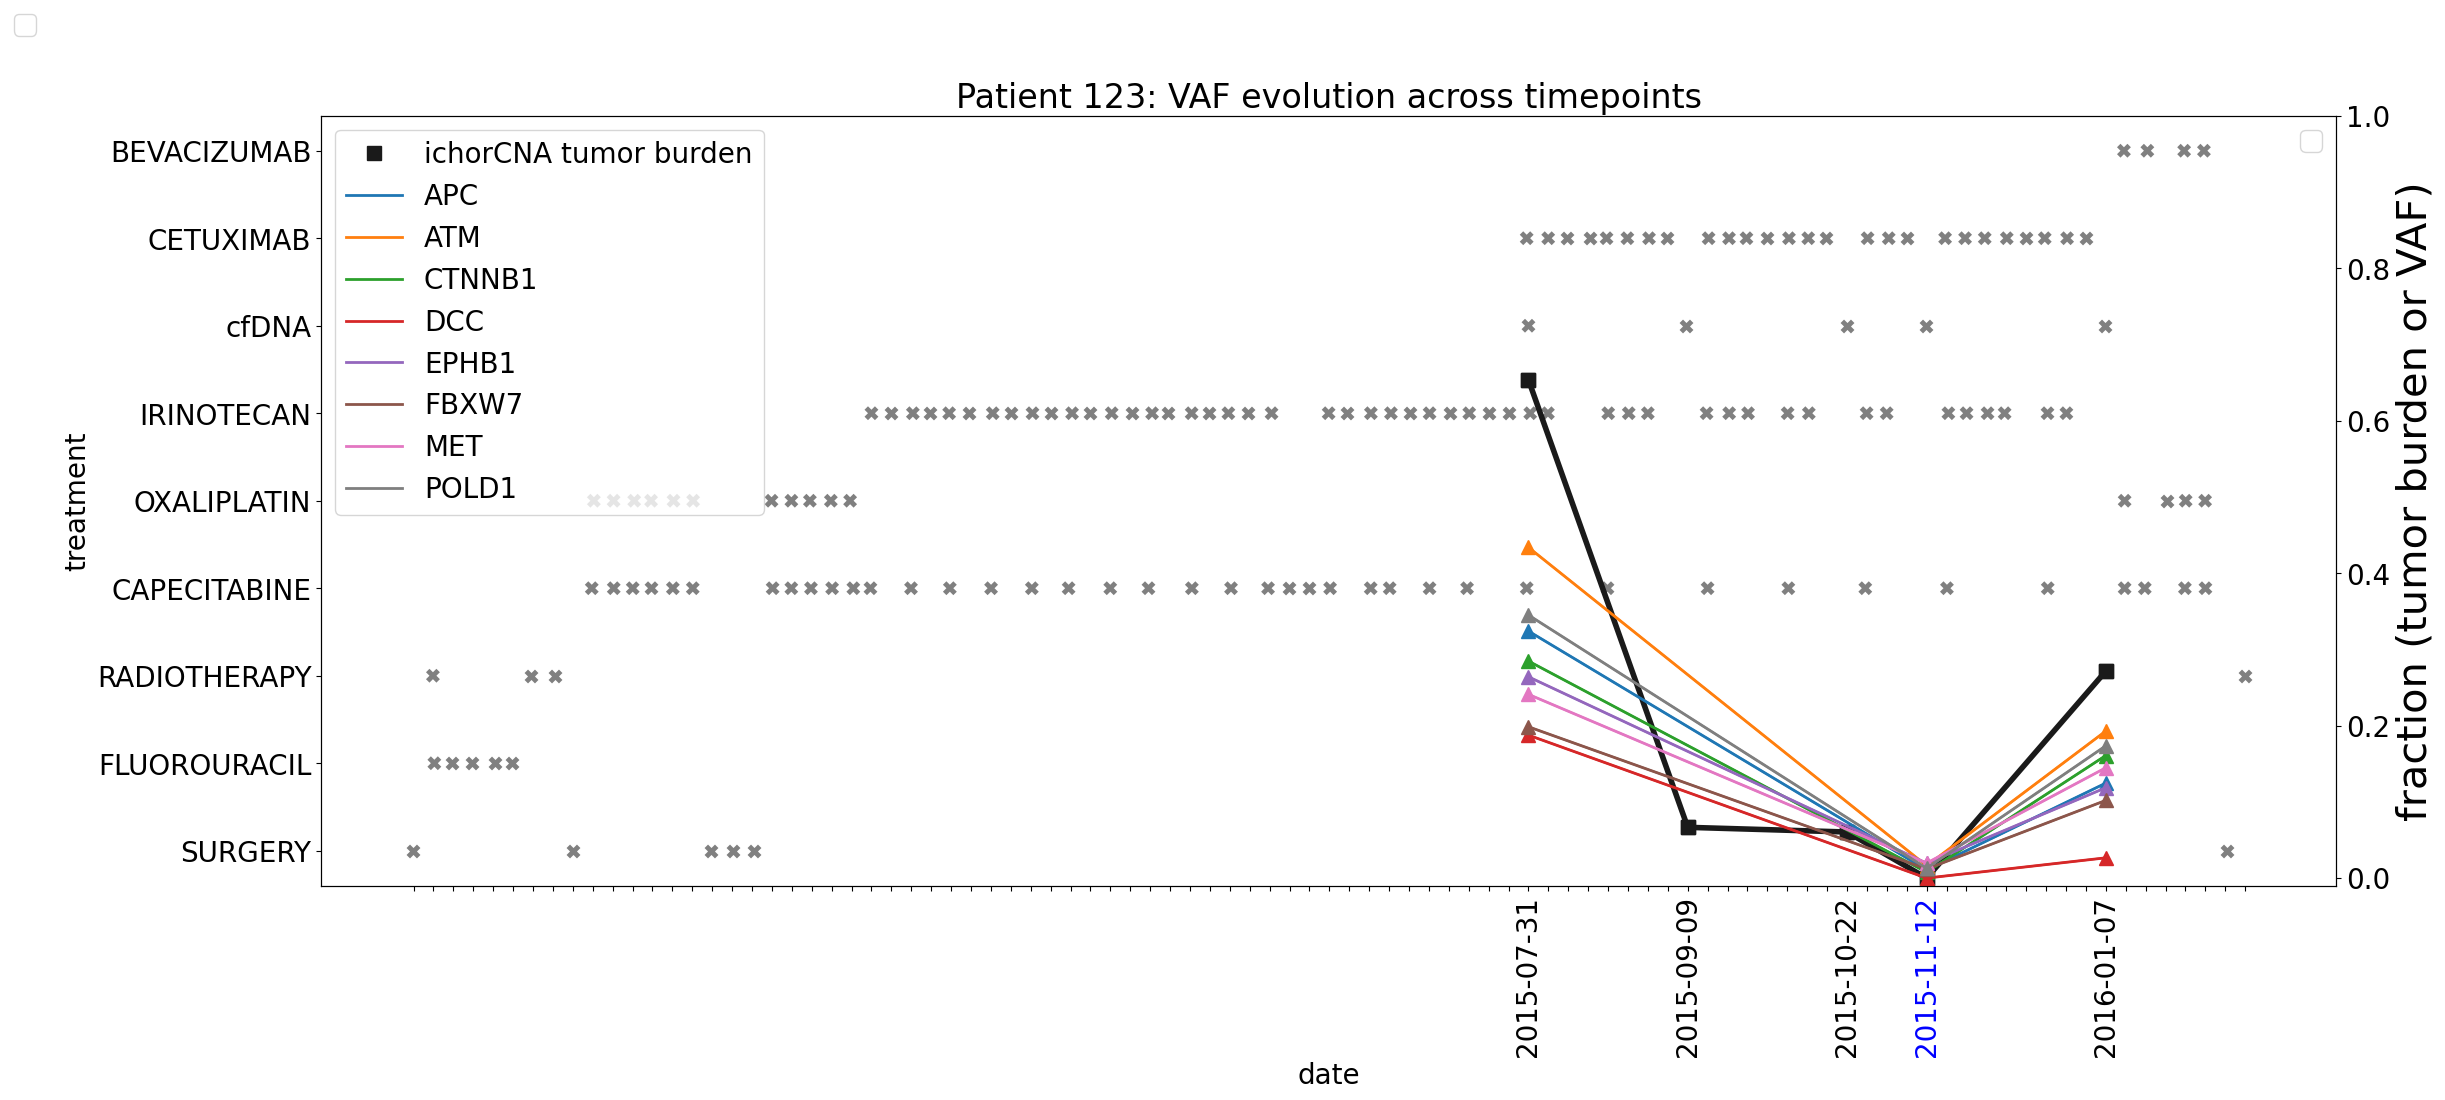

1014
['2016-08-18']


<Figure size 640x480 with 0 Axes>

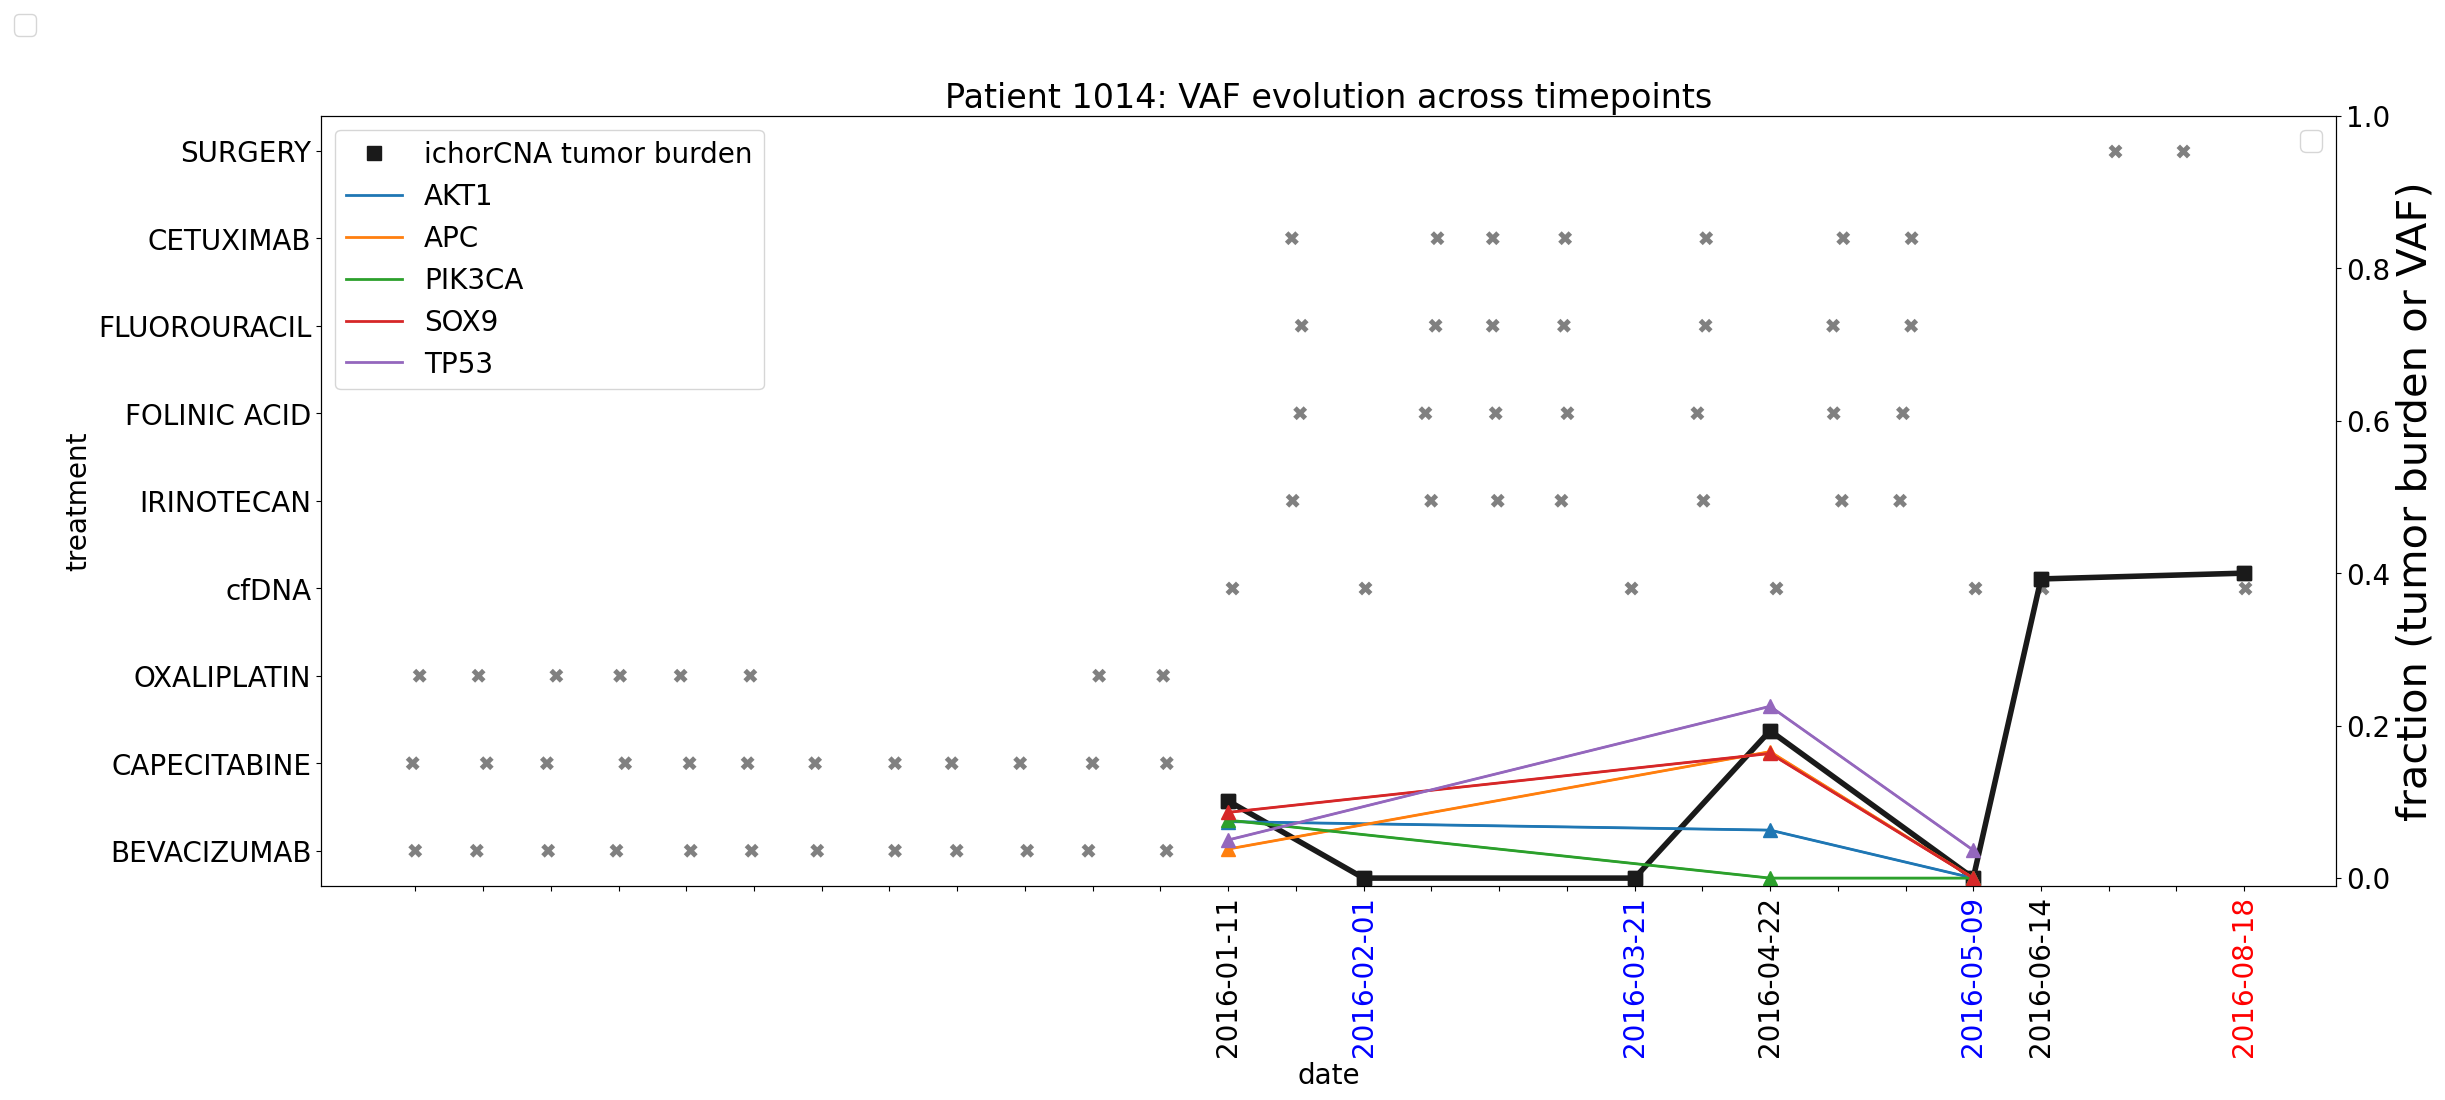

In [173]:
for patient in [986, 123, 1014]:
    res = plot_patient_timeline(config, patient, figsize=(26, 10), mutations=True)
    lowtftimepoints_pd = get_mutations_stats(config, patient)
    lowtftimepoints_pd.dropna()

In [174]:
res

,#CHROM,POS,REF,ALT,GENE,TIERS,helper,CCG_226_1014.090516,CCG_226_1014.110116,CCG_226_1014.220416
30,chr3,179234297,A,G,PIK3CA,Trusted,hello,0 / 150 = 0.000,13 / 171 = 0.076,0 / 635 = 0.000
38,chr5,112839783,G,T,APC,Trusted,hello,0 / 193 = 0.000,4 / 105 = 0.038,101 / 609 = 0.166
56,chr14,104773077,C,A,AKT1,Trusted,hello,0 / 154 = 0.000,6 / 81 = 0.074,46 / 731 = 0.063
57,chr17,7675111,CTG,C,TP53,Trusted,hello,3 / 82 = 0.037,2 / 40 = 0.050,105 / 466 = 0.225
58,chr17,72122793,A,T,SOX9,Trusted,hello,0 / 163 = 0.000,5 / 58 = 0.086,85 / 520 = 0.163


# Paired plots and trusted VAFs

In [5]:
seqtype = 'targeted'
patient = '123'
variable = 'vaf'

## Patient 1014 - APC
chr5_112839783 	# hg38

5_112175480 	# hg19

## Patient 123 - EPHB1 

chr3_134951440 # hg38

3_134670282 # hg 19

In [6]:
# ultra low TF sample
print(patientsample_dict[patient][2])
lowtfsample_vaf_df = pd.read_csv(os.path.join(*config.lowtfsamplesfolder, 'targeted', patientsample_dict[patient][2] + '_' + seqtype + '_vaf.txt'), index_col=0)
lowtfsample_vaf_df['chrom_pos'] = lowtfsample_vaf_df['chrom'].astype('str').str.cat(lowtfsample_vaf_df['pos'].astype('str'), sep="_")
lowtfsample_vaf_df.set_index('chrom_pos', inplace=True)
lowtfsample_vaf_df = lowtfsample_vaf_df.loc[~lowtfsample_vaf_df.index.duplicated()]
lowtfsample_vaf_df['annotation'] = 'No annotation'
mutationfile = pd.read_excel(os.path.join(*config.mutationfolder, [f for f in os.listdir(os.path.join(*config.mutationfolder)) if f.startswith('CCG_226_'+patient)][0]))
mutationfile['chrom_pos'] = mutationfile['#CHROM'].astype('str').str.cat(mutationfile['POS'].astype('str'), sep="_")
mutationfile.set_index('chrom_pos', inplace=True)
mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
for c in list(mutationfile.columns[13:-1]):
    if (sum([p.split('-')[1].split('_')[1] in c for p in patientsample_dict[patient]]) == 0) and (c != 'CCG_226_986.110215.P'):
        mutationfile.drop(c, axis=1, inplace=True)
ctokeep = [c for c in mutationfile.columns if c.startswith('CCG') or c.startswith(patient)]
mutationfile[mutationfile['TIERS'] == 'Trusted'][['REF', 'ALT', 'GENE', *ctokeep]]
if seqtype == 'deepWGS':
    mutationfile.reset_index(inplace=True)
    for i in range(mutationfile.shape[0]):
        if mutationfile['chrom_pos'].iloc[i] in targetbedhg38list:
            val = targetbedhg19list[targetbedhg38list.index(mutationfile['chrom_pos'].iloc[i])]
            mutationfile.iat[i, 0] = val
        else:
            mutationfile.iloc[i]['chrom_pos'] = np.nan
    # mutationfile['chrom_pos'].apply(lambda x: targetbedhg19list[targetbedhg38list.index(x)])
    mutationfile['chrom_pos'] = mutationfile['chrom_pos'].apply(lambda x: x.split('_')[0][:3] + '_' + x.split('_')[1]) ###
    mutationfile.set_index('chrom_pos', inplace=True)
    mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
lowtfsample_vaf_df.loc[list(set(mutationfile.index) & set(lowtfsample_vaf_df.index)), 'annotation'] = mutationfile['TIERS']
lowtfsample_vaf_df = lowtfsample_vaf_df[lowtfsample_vaf_df['annotation'] == 'Trusted']
lowtfsample_vaf_df['gene'] = mutationfile.loc[lowtfsample_vaf_df.index, 'GENE']
lowtfsample_vaf_df['ref'] = mutationfile.loc[lowtfsample_vaf_df.index, 'REF']
lowtfsample_vaf_df['alt'] = mutationfile.loc[lowtfsample_vaf_df.index, 'ALT']
lowtfsample_vaf_df['pileup'].fillna('', inplace=True)
lowtfsample_vaf_df['pileup'] = lowtfsample_vaf_df['pileup'].astype(str)
lowtfsample_vaf_df['supporting altcov'] = lowtfsample_vaf_df[['pileup', 'alt', 'ref']].apply(lambda x: x[0].count(x[1]) if (len(x[1]) == 1) and (len(x[2]) == 1) else x[0].count('+'+str(len(x[1][1:]))+x[1][1:]) if len(x[1]) > 1 else x[0].count('-'+str(len(x[2][1:]))+x[2][1:]), axis=1)
lowtfsample_vaf_df['supporting vaf'] = lowtfsample_vaf_df['supporting altcov']/lowtfsample_vaf_df['totcov']
# print('Median VAF= {}%'.format(round(100*lowtfsample_vaf_df['supporting vaf'].median(), 1)))
print('Max VAF= {}%'.format(round(100*lowtfsample_vaf_df['supporting vaf'].max(), 1)))
lowtfsample_vaf_df['res'] = lowtfsample_vaf_df['gene'].astype(str) + ' (' + lowtfsample_vaf_df['ref'].astype(str) + '>' + lowtfsample_vaf_df['alt'].astype(str) + '): VAF=' + lowtfsample_vaf_df['supporting vaf'].round(6).astype(str) + ' ('+ lowtfsample_vaf_df['supporting altcov'].astype(int).astype(str) + '/' + lowtfsample_vaf_df['totcov'].astype(str) + ')' 
print(lowtfsample_vaf_df.reset_index()['res'])
for i in range(lowtfsample_vaf_df.shape[0]):
    print(Counter(lowtfsample_vaf_df['pileup'].iloc[i]))
lowtfsample_vaf_df[['res', 'pileup']]

NCC_CRC-123_121115-CW-T
Max VAF= 2.6%
0     APC (AC>A): VAF=0.020179 (144/7136)
1      ATM (C>T): VAF=0.015551 (108/6945)
2    CTNNB1 (T>G): VAF=0.003303 (18/5449)
3             DCC (G>C): VAF=0.0 (0/6468)
4     EPHB1 (G>A): VAF=0.006944 (51/7344)
5     FBXW7 (C>T): VAF=0.02573 (164/6374)
6      MET (T>C): VAF=0.019837 (134/6755)
7     POLD1 (C>T): VAF=0.008924 (57/6387)
Name: res, dtype: object
Counter({'-': 144, '1': 144, 'C': 144})
Counter({'T': 108, 'A': 1})
Counter({'G': 18, 'C': 2})
Counter({'A': 1})
Counter({'A': 51, 'T': 1})
Counter({'T': 164})
Counter({'C': 134})
Counter({'T': 57, 'A': 1})


,res,pileup
chrom_pos,,
chr5_112838398,APC (AC>A): VAF=0.020179 (144/7136),-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-...
chr11_108365359,ATM (C>T): VAF=0.015551 (108/6945),TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...
chr3_41233420,CTNNB1 (T>G): VAF=0.003303 (18/5449),CCGGGGGGGGGGGGGGGGGG
chr18_53416135,DCC (G>C): VAF=0.0 (0/6468),A
chr3_134951440,EPHB1 (G>A): VAF=0.006944 (51/7344),AATAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
chr4_152328232,FBXW7 (C>T): VAF=0.02573 (164/6374),TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...
chr7_116699125,MET (T>C): VAF=0.019837 (134/6755),CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
chr19_50402340,POLD1 (C>T): VAF=0.008924 (57/6387),TTTTTTTTTTTTTTTTTTTTTTTTATTTTTTTTTTTTTTTTTTTTT...


In [7]:
aux = lowtfsample_vaf_df['pileup'].iloc[4]
aux.replace('-2TG', '.')

'AATAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'

In [8]:
# high TF sample 1
print(patientsample_dict[patient][0])
hightfsample_vaf_df = pd.read_csv(os.path.join(*config.lowtfsamplesfolder, 'targeted', patientsample_dict[patient][0] + '_' + seqtype + '_vaf.txt'), index_col=0)
hightfsample_vaf_df['chrom_pos'] = hightfsample_vaf_df['chrom'].astype('str').str.cat(hightfsample_vaf_df['pos'].astype('str'), sep="_")
hightfsample_vaf_df.set_index('chrom_pos', inplace=True)
hightfsample_vaf_df = hightfsample_vaf_df.loc[~hightfsample_vaf_df.index.duplicated()]
hightfsample_vaf_df['annotation'] = 'No annotation'
mutationfile = pd.read_excel(os.path.join(*config.mutationfolder, [f for f in os.listdir(os.path.join(*config.mutationfolder)) if f.startswith('CCG_226_'+patient)][0]))
mutationfile['chrom_pos'] = mutationfile['#CHROM'].astype('str').str.cat(mutationfile['POS'].astype('str'), sep="_")
mutationfile.set_index('chrom_pos', inplace=True)
mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
for c in list(mutationfile.columns[13:-1]):
    if (sum([p.split('-')[1].split('_')[1] in c for p in patientsample_dict[patient]]) == 0) and (c != 'CCG_226_986.110215.P'):
        mutationfile.drop(c, axis=1, inplace=True)
ctokeep = [c for c in mutationfile.columns if c.startswith('CCG') or c.startswith(patient)]
mutationfile[mutationfile['TIERS'] == 'Trusted'][['REF', 'ALT', 'GENE', *ctokeep]]
if seqtype == 'deepWGS':
    mutationfile.reset_index(inplace=True)
    for i in range(mutationfile.shape[0]):
        if mutationfile['chrom_pos'].iloc[i] in targetbedhg38list:
            val = targetbedhg19list[targetbedhg38list.index(mutationfile['chrom_pos'].iloc[i])]
            mutationfile.iat[i, 0] = val
        else:
            mutationfile.iloc[i]['chrom_pos'] = np.nan
    # mutationfile['chrom_pos'].apply(lambda x: targetbedhg19list[targetbedhg38list.index(x)])
    mutationfile['chrom_pos'] = mutationfile['chrom_pos'].apply(lambda x: x.split('_')[0][:3] + '_' + x.split('_')[1]) ###
    mutationfile.set_index('chrom_pos', inplace=True)
    mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
hightfsample_vaf_df.loc[list(set(mutationfile.index) & set(hightfsample_vaf_df.index)), 'annotation'] = mutationfile['TIERS']

hightfsample_vaf_df = hightfsample_vaf_df[hightfsample_vaf_df['annotation'] != 'No annotation']
#sns.scatterplot(x='totcov', y='vaf', hue='annotation', s=20, data=hightfsample_vaf_df)
#plt.xlim([0, 10000])
#plt.ylim([0, max(hightfsample_vaf_df[hightfsample_vaf_df['annotation'] != 'Germline']['vaf'])])
#plt.gca().legend(bbox_to_anchor=(1, 1), loc="upper left")
#plt.show()

hightfsample_vaf_df = hightfsample_vaf_df[hightfsample_vaf_df['annotation'] == 'Trusted']
hightfsample_vaf_df['gene'] = mutationfile.loc[hightfsample_vaf_df.index, 'GENE']
hightfsample_vaf_df['ref'] = mutationfile.loc[hightfsample_vaf_df.index, 'REF']
hightfsample_vaf_df['alt'] = mutationfile.loc[hightfsample_vaf_df.index, 'ALT']
hightfsample_vaf_df['pileup'].fillna('', inplace=True)
hightfsample_vaf_df['pileup'] = hightfsample_vaf_df['pileup'].astype(str)
hightfsample_vaf_df['supporting altcov'] = hightfsample_vaf_df[['pileup', 'alt', 'ref']].apply(lambda x: x[0].count(x[1]) if (len(x[1]) == 1) and (len(x[2]) == 1) else x[0].count('+'+str(len(x[1][1:]))+x[1][1:]) if len(x[1]) > 1 else x[0].count('-'+str(len(x[2][1:]))+x[2][1:]), axis=1)
hightfsample_vaf_df['supporting vaf'] = hightfsample_vaf_df['supporting altcov']/hightfsample_vaf_df['totcov']
print('Median VAF= {}%'.format(round(100*hightfsample_vaf_df['supporting vaf'].median(), 1)))
print('Max VAF= {}%'.format(round(100*hightfsample_vaf_df['supporting vaf'].max(), 1)))
hightfsample_vaf_df['res'] = hightfsample_vaf_df['gene'].astype(str) + ' (' + hightfsample_vaf_df['ref'].astype(str) + '>' + hightfsample_vaf_df['alt'].astype(str) + '): VAF=' + hightfsample_vaf_df['supporting vaf'].round(6).astype(str) + ' ('+ hightfsample_vaf_df['supporting altcov'].astype(int).astype(str) + '/' + hightfsample_vaf_df['totcov'].astype(str) + ')' 
print(hightfsample_vaf_df.reset_index()['res'])
for i in range(hightfsample_vaf_df.shape[0]):
    print(Counter(hightfsample_vaf_df['pileup'].iloc[i]))
hightfsample_vaf_df[['res', 'pileup']]

NCC_CRC-123_310715-CW-T
Median VAF= 26.5%
Max VAF= 45.2%
0      APC (AC>A): VAF=0.334916 (1622/4843)
1       ATM (C>T): VAF=0.452354 (1595/3526)
2    CTNNB1 (T>G): VAF=0.276083 (1122/4064)
3        DCC (G>C): VAF=0.185363 (542/2924)
4     EPHB1 (G>A): VAF=0.254679 (1388/5450)
5      FBXW7 (C>T): VAF=0.196672 (910/4627)
6       MET (T>C): VAF=0.228401 (1150/5035)
7     POLD1 (C>T): VAF=0.344775 (1798/5215)
Name: res, dtype: object
Counter({'-': 1622, '1': 1622, 'C': 1622, 'T': 2, 'G': 1})
Counter({'T': 1595, 'A': 1})
Counter({'G': 1122})
Counter({'C': 542})
Counter({'A': 1388})
Counter({'T': 910})
Counter({'C': 1150, 'A': 1})
Counter({'T': 1798})


,res,pileup
chrom_pos,,
chr5_112838398,APC (AC>A): VAF=0.334916 (1622/4843),-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-...
chr11_108365359,ATM (C>T): VAF=0.452354 (1595/3526),TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...
chr3_41233420,CTNNB1 (T>G): VAF=0.276083 (1122/4064),GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...
chr18_53416135,DCC (G>C): VAF=0.185363 (542/2924),CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
chr3_134951440,EPHB1 (G>A): VAF=0.254679 (1388/5450),AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
chr4_152328232,FBXW7 (C>T): VAF=0.196672 (910/4627),TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...
chr7_116699125,MET (T>C): VAF=0.228401 (1150/5035),CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
chr19_50402340,POLD1 (C>T): VAF=0.344775 (1798/5215),TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...


In [9]:
aux = hightfsample_vaf_df['pileup'].iloc[0]
aux.replace('-1C', '.')

'............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................G..........................................................................................................................................................................................................................................................

In [10]:
print(patientsample_dict[patient][1])
hightfsample_vaf_df = pd.read_csv(os.path.join(*config.lowtfsamplesfolder, 'targeted', patientsample_dict[patient][1] + '_' + seqtype + '_vaf.txt'), index_col=0)
hightfsample_vaf_df['chrom_pos'] = hightfsample_vaf_df['chrom'].astype('str').str.cat(hightfsample_vaf_df['pos'].astype('str'), sep="_")
hightfsample_vaf_df.set_index('chrom_pos', inplace=True)
hightfsample_vaf_df = hightfsample_vaf_df.loc[~hightfsample_vaf_df.index.duplicated()]
hightfsample_vaf_df['annotation'] = 'No annotation'
mutationfile = pd.read_excel(os.path.join(*config.mutationfolder, [f for f in os.listdir(os.path.join(*config.mutationfolder)) if f.startswith('CCG_226_'+patient)][0]))
mutationfile['chrom_pos'] = mutationfile['#CHROM'].astype('str').str.cat(mutationfile['POS'].astype('str'), sep="_")
mutationfile.set_index('chrom_pos', inplace=True)
mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
for c in list(mutationfile.columns[13:-1]):
    if (sum([p.split('-')[1].split('_')[1] in c for p in patientsample_dict[patient]]) == 0) and (c != 'CCG_226_986.110215.P'):
        mutationfile.drop(c, axis=1, inplace=True)
ctokeep = [c for c in mutationfile.columns if c.startswith('CCG') or c.startswith(patient)]
mutationfile[mutationfile['TIERS'] == 'Trusted'][['REF', 'ALT', 'GENE', *ctokeep]]
if seqtype == 'deepWGS':
    mutationfile.reset_index(inplace=True)
    for i in range(mutationfile.shape[0]):
        if mutationfile['chrom_pos'].iloc[i] in targetbedhg38list:
            val = targetbedhg19list[targetbedhg38list.index(mutationfile['chrom_pos'].iloc[i])]
            mutationfile.iat[i, 0] = val
        else:
            mutationfile.iloc[i]['chrom_pos'] = np.nan
    # mutationfile['chrom_pos'].apply(lambda x: targetbedhg19list[targetbedhg38list.index(x)])
    mutationfile['chrom_pos'] = mutationfile['chrom_pos'].apply(lambda x: x.split('_')[0][:3] + '_' + x.split('_')[1]) ###
    mutationfile.set_index('chrom_pos', inplace=True)
    mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
hightfsample_vaf_df.loc[list(set(mutationfile.index) & set(hightfsample_vaf_df.index)), 'annotation'] = mutationfile['TIERS']
hightfsample_vaf_df = hightfsample_vaf_df[hightfsample_vaf_df['annotation'] == 'Trusted']
hightfsample_vaf_df['gene'] = mutationfile.loc[hightfsample_vaf_df.index, 'GENE']
hightfsample_vaf_df['ref'] = mutationfile.loc[hightfsample_vaf_df.index, 'REF']
hightfsample_vaf_df['alt'] = mutationfile.loc[hightfsample_vaf_df.index, 'ALT']
hightfsample_vaf_df['pileup'].fillna('', inplace=True)
hightfsample_vaf_df['pileup'] = hightfsample_vaf_df['pileup'].astype(str)
hightfsample_vaf_df['supporting altcov'] = hightfsample_vaf_df[['pileup', 'alt', 'ref']].apply(lambda x: x[0].count(x[1]) if (len(x[1]) == 1) and (len(x[2]) == 1) else x[0].count('+'+str(len(x[1][1:]))+x[1][1:]) if len(x[1]) > 1 else x[0].count('-'+str(len(x[2][1:]))+x[2][1:]), axis=1)
hightfsample_vaf_df['supporting vaf'] = hightfsample_vaf_df['supporting altcov']/hightfsample_vaf_df['totcov']
print('Median VAF= {}%'.format(round(100*hightfsample_vaf_df['supporting vaf'].median(), 1)))
print('Max VAF= {}%'.format(round(100*hightfsample_vaf_df['supporting vaf'].max(), 1)))
hightfsample_vaf_df['res'] = hightfsample_vaf_df['gene'].astype(str) + ' (' + hightfsample_vaf_df['ref'].astype(str) + '>' + hightfsample_vaf_df['alt'].astype(str) + '): VAF=' + hightfsample_vaf_df['supporting vaf'].round(6).astype(str) + ' ('+ hightfsample_vaf_df['supporting altcov'].astype(int).astype(str) + '/' + hightfsample_vaf_df['totcov'].astype(str) + ')' 
print(hightfsample_vaf_df.reset_index()['res'])
for i in range(hightfsample_vaf_df.shape[0]):
    print(Counter(hightfsample_vaf_df['pileup'].iloc[i]))
hightfsample_vaf_df[['res', 'pileup']]

NCC_CRC-123_070116-CW-T
Median VAF= 13.4%
Max VAF= 18.9%
0      APC (AC>A): VAF=0.113033 (758/6706)
1      ATM (C>T): VAF=0.188717 (1124/5956)
2    CTNNB1 (T>G): VAF=0.149905 (790/5270)
3        DCC (G>C): VAF=0.009869 (52/5269)
4     EPHB1 (G>A): VAF=0.117589 (835/7101)
5     FBXW7 (C>T): VAF=0.084307 (476/5646)
6       MET (T>C): VAF=0.150646 (956/6346)
7     POLD1 (C>T): VAF=0.17212 (1052/6112)
Name: res, dtype: object
Counter({'-': 758, '1': 758, 'C': 758, 'T': 9, 'G': 1})
Counter({'T': 1124, 'A': 1})
Counter({'G': 790, 'A': 1})
Counter({'C': 52})
Counter({'A': 835})
Counter({'T': 476})
Counter({'C': 956, 'A': 1})
Counter({'T': 1052})


,res,pileup
chrom_pos,,
chr5_112838398,APC (AC>A): VAF=0.113033 (758/6706),-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-1C-...
chr11_108365359,ATM (C>T): VAF=0.188717 (1124/5956),TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...
chr3_41233420,CTNNB1 (T>G): VAF=0.149905 (790/5270),GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...
chr18_53416135,DCC (G>C): VAF=0.009869 (52/5269),CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
chr3_134951440,EPHB1 (G>A): VAF=0.117589 (835/7101),AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
chr4_152328232,FBXW7 (C>T): VAF=0.084307 (476/5646),TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...
chr7_116699125,MET (T>C): VAF=0.150646 (956/6346),CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
chr19_50402340,POLD1 (C>T): VAF=0.17212 (1052/6112),TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...


In [11]:
aux = hightfsample_vaf_df['pileup'].iloc[3]
aux.replace('T', '.')

'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'

# Paired plots logscale and same scale

deepWGS
0
0
             986_300316  986_100215    gene
chrom_pos                                  
5_112128143         0.0    0.210526     APC
1_23222037          0.0    0.000000   EPHB2
3_178936092         0.0    0.302326  PIK3CA
17_70119758         0.0    0.153846    SOX9
17_7578394          0.0    0.407407    TP53
986_100215
targeted
0
0.000999666777740753
                986_300316  986_100215    gene
chrom_pos                                     
chr5_112792446    -0.00015    0.150547     APC
chr1_22895544      0.00000    0.000000   EPHB2
chr3_179218304     0.00100    0.225434  PIK3CA
chr17_72123617     0.00000    0.150919    SOX9
chr17_7675076      0.00000    0.306679    TP53
986_100215


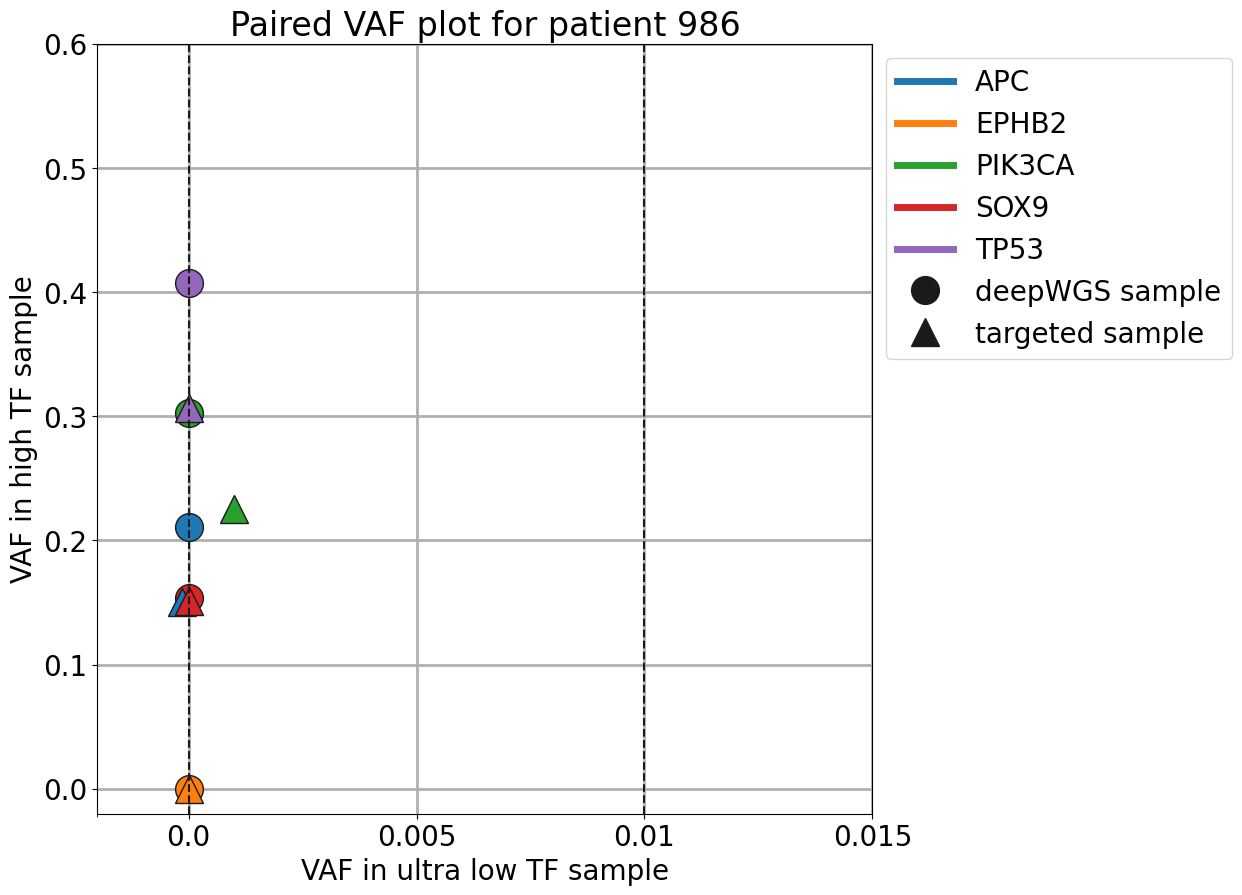

deepWGS
0
0.04081632653061224
              123_121115  123_310715    gene
chrom_pos                                   
5_112174095     0.011765    0.289474     APC
11_108236086    0.021053    0.565217     ATM
3_41274911      0.000000    0.312500  CTNNB1
18_50942505     0.010309    0.240000     DCC
3_134670282     0.040816    0.343750   EPHB1
4_153249384     0.000000    0.240000   FBXW7
7_116339179     0.000000    0.203390     MET
19_50905597     0.000000    0.298851   POLD1
123_310715
targeted
0
0.04081632653061224
                 123_121115  123_310715    gene
chrom_pos                                      
chr5_112838398     0.020179    0.334916     APC
chr11_108365359    0.015551    0.452354     ATM
chr3_41233420      0.003303    0.276083  CTNNB1
chr18_53416135     0.000000    0.185363     DCC
chr3_134951440     0.006944    0.254679   EPHB1
chr4_152328232     0.025730    0.196672   FBXW7
chr7_116699125     0.019837    0.228401     MET
chr19_50402340     0.008924    0.344775   POLD

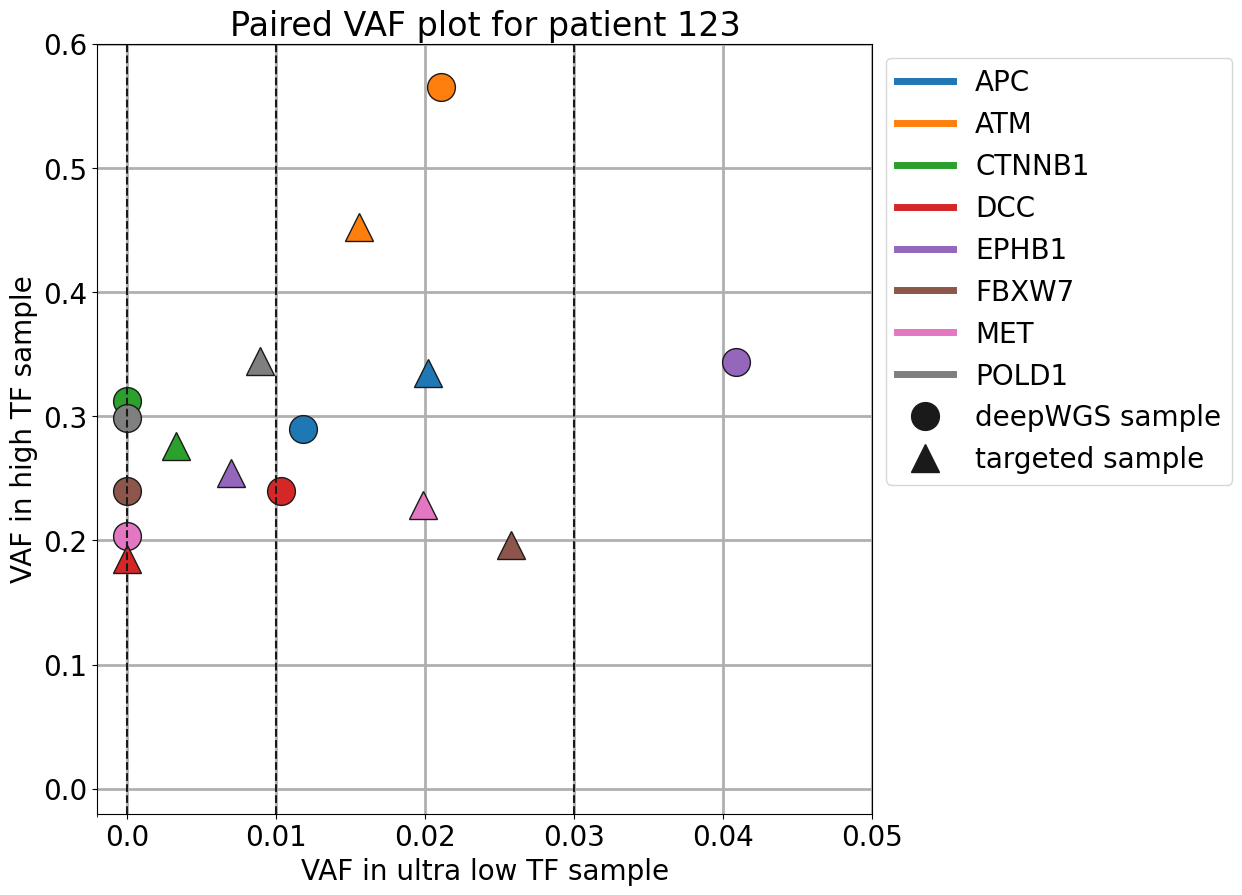

deepWGS
0
0.018691588785046728
              1014_090516  1014_180816    gene
chrom_pos                                     
14_105239414     0.006757     0.203125    AKT1
5_112175480      0.018692     0.448276     APC
3_178952085      0.000000     0.000000  PIK3CA
17_70118934      0.016000     0.117647    SOX9
17_7578429       0.016129     0.435897    TP53
1014_180816
targeted
0
0.03301491536785654
                 1014_090516  1014_180816    gene
chrom_pos                                        
chr14_104773077     0.000000     0.191646    AKT1
chr5_112839783      0.000000     0.457848     APC
chr3_179234297      0.000000     0.000000  PIK3CA
chr17_72122793      0.000182     0.283012    SOX9
chr17_7675111       0.033015     0.495875    TP53
1014_180816


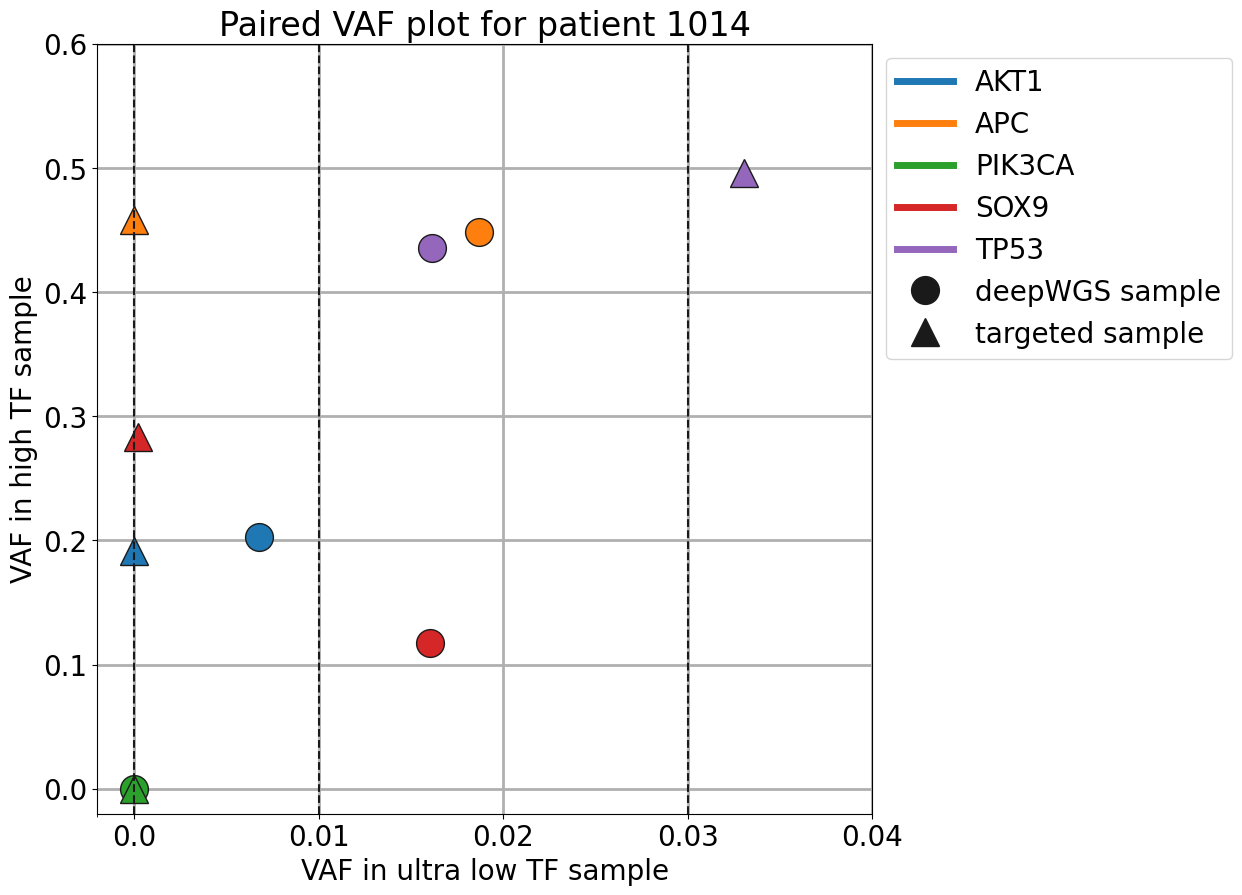

In [175]:
markers = ['o', '^']
alphas = [1, 0.5]
fillstyles=['full', 'none']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey']


for patient in ['986', '123', '1014']:
    plt.figure(figsize=(10,10))
    plt.grid()

    maxx = 0
    for si, seqtype in enumerate([ 'deepWGS', 'targeted']):

        mutationfile = pd.read_excel(os.path.join(*config.mutationfolder, [f for f in os.listdir(os.path.join(*config.mutationfolder)) if f.startswith('CCG_226_'+patient)][0]))
        mutationfile['chrom_pos'] = mutationfile['#CHROM'].astype('str').str.cat(mutationfile['POS'].astype('str'), sep="_")
        mutationfile.set_index('chrom_pos', inplace=True)
        mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
        for c in list(mutationfile.columns[13:-1]):
            if (sum([p.split('-')[1].split('_')[1] in c for p in patientsample_dict[patient]]) == 0) and (c != 'CCG_226_986.110215.P'):
                mutationfile.drop(c, axis=1, inplace=True)
        ctokeep = [c for c in mutationfile.columns if c.startswith('CCG') or c.startswith(patient)]
        mutationfile[mutationfile['TIERS'] == 'Trusted'][['REF', 'ALT', 'GENE', *ctokeep]]

        print(seqtype)
        lowtfsample_vaf_df = pd.read_csv(os.path.join(*config.lowtfsamplesfolder, 'targeted', patientsample_dict[patient][2] + '_' + seqtype + '_vaf.txt'), index_col=0)
        lowtfsample_vaf_df['chrom_pos'] = lowtfsample_vaf_df['chrom'].astype('str').str.cat(lowtfsample_vaf_df['pos'].astype('str'), sep="_")
        lowtfsample_vaf_df.set_index('chrom_pos', inplace=True)
        lowtfsample_vaf_df = lowtfsample_vaf_df.loc[~lowtfsample_vaf_df.index.duplicated()]
        lowtfsample_vaf_df['annotation'] = 'No annotation'
        if seqtype == 'deepWGS':
            mutationfile.reset_index(inplace=True)
            for i in range(mutationfile.shape[0]):
                if mutationfile['chrom_pos'].iloc[i] in targetbedhg38list:
                    val = targetbedhg19list[targetbedhg38list.index(mutationfile['chrom_pos'].iloc[i])]
                    mutationfile.iat[i, 0] = val
                else:
                    mutationfile.iloc[i]['chrom_pos'] = np.nan
            mutationfile['chrom_pos'] = mutationfile['chrom_pos'].apply(lambda x: x.split('_')[0][:3] + '_' + x.split('_')[1]) ###
            mutationfile.set_index('chrom_pos', inplace=True)
            mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
        mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
        lowtfsample_vaf_df.loc[list(set(mutationfile.index) & set(lowtfsample_vaf_df.index)), 'annotation'] = mutationfile['TIERS']
        lowtfsample_vaf_df = lowtfsample_vaf_df[lowtfsample_vaf_df['annotation'] == 'Trusted'] #  != 'No annotation'
        lowtfsample_vaf_df['gene'] = mutationfile.loc[lowtfsample_vaf_df.index, 'GENE']
        lowtfsample_vaf_df['ref'] = mutationfile.loc[lowtfsample_vaf_df.index, 'REF']
        lowtfsample_vaf_df['alt'] = mutationfile.loc[lowtfsample_vaf_df.index, 'ALT']
        lowtfsample_vaf_df['pileup'].fillna('', inplace=True)
        lowtfsample_vaf_df['pileup'] = lowtfsample_vaf_df['pileup'].astype(str)
        lowtfsample_vaf_df['supporting altcov'] = lowtfsample_vaf_df[['pileup', 'alt', 'ref']].apply(lambda x: x[0].count(x[1]) if (len(x[1]) == 1) and (len(x[2]) == 1) else x[0].count('+'+str(len(x[1][1:]))+x[1][1:]) if len(x[1]) > 1 else x[0].count('-'+str(len(x[2][1:]))+x[2][1:]), axis=1)
        lowtfsample_vaf_df['supporting vaf'] = lowtfsample_vaf_df['supporting altcov']/lowtfsample_vaf_df['totcov']
        for pi in range(1):
            print(pi)
            hightfsample_vaf_df = pd.read_csv(os.path.join(*config.lowtfsamplesfolder, 'targeted', patientsample_dict[patient][pi] + '_' + seqtype + '_vaf.txt'), index_col=0)
            hightfsample_vaf_df['chrom_pos'] = hightfsample_vaf_df['chrom'].astype('str').str.cat(hightfsample_vaf_df['pos'].astype('str'), sep="_")
            hightfsample_vaf_df.set_index('chrom_pos', inplace=True)
            hightfsample_vaf_df = hightfsample_vaf_df.loc[~hightfsample_vaf_df.index.duplicated()]
            hightfsample_vaf_df['annotation'] = 'No annotation'
            if seqtype == 'deepWGS':
                mutationfile.reset_index(inplace=True)
                for i in range(mutationfile.shape[0]):
                    if mutationfile['chrom_pos'].iloc[i] in targetbedhg38list:
                        val = targetbedhg19list[targetbedhg38list.index(mutationfile['chrom_pos'].iloc[i])]
                        mutationfile.iat[i, 0] = val
                    else:
                        mutationfile.iloc[i]['chrom_pos'] = np.nan
                # mutationfile['chrom_pos'].apply(lambda x: targetbedhg19list[targetbedhg38list.index(x)])
                mutationfile['chrom_pos'] = mutationfile['chrom_pos'].apply(lambda x: x.split('_')[0][:3] + '_' + x.split('_')[1]) ###
                mutationfile.set_index('chrom_pos', inplace=True)
                mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
            mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
            hightfsample_vaf_df.loc[list(set(mutationfile.index) & set(hightfsample_vaf_df.index)), 'annotation'] = mutationfile['TIERS']
            hightfsample_vaf_df = hightfsample_vaf_df[hightfsample_vaf_df['annotation'] == 'Trusted'] #  != 'No annotation'
            hightfsample_vaf_df['gene'] = mutationfile.loc[hightfsample_vaf_df.index, 'GENE']
            hightfsample_vaf_df['ref'] = mutationfile.loc[hightfsample_vaf_df.index, 'REF']
            hightfsample_vaf_df['alt'] = mutationfile.loc[hightfsample_vaf_df.index, 'ALT']
            hightfsample_vaf_df['pileup'].fillna('', inplace=True)
            hightfsample_vaf_df['pileup'] = hightfsample_vaf_df['pileup'].astype(str)
            hightfsample_vaf_df['supporting altcov'] = hightfsample_vaf_df[['pileup', 'alt', 'ref']].apply(lambda x: x[0].count(x[1]) if (len(x[1]) == 1) and (len(x[2]) == 1) else x[0].count('+'+str(len(x[1][1:]))+x[1][1:]) if len(x[1]) > 1 else x[0].count('-'+str(len(x[2][1:]))+x[2][1:]), axis=1)
            hightfsample_vaf_df['supporting vaf'] = hightfsample_vaf_df['supporting altcov']/hightfsample_vaf_df['totcov']

            paired_vaf = pd.concat([lowtfsample_vaf_df[lowtfsample_vaf_df['annotation'] == 'Trusted'][['supporting vaf']],
                                    hightfsample_vaf_df[hightfsample_vaf_df['annotation'] == 'Trusted'][['supporting vaf']]], axis=1)
            paired_vaf.columns = [patientsample_dict[patient][2].split('-')[1], patientsample_dict[patient][pi].split('-')[1]]
            maxx = paired_vaf[patientsample_dict[patient][2].split('-')[1]].max() if paired_vaf[patientsample_dict[patient][2].split('-')[1]].max() > maxx else maxx
            print(maxx)
            paired_vaf['gene'] = mutationfile.loc[paired_vaf.index, 'GENE']
            if patient == '986' and seqtype == 'targeted':
                paired_vaf.iat[0,0] = -0.00015 # (intead of 0 for APC, for visualisation)
            print(paired_vaf)
            print(patientsample_dict[patient][pi].split('-')[1])
            for gi, g in enumerate(list(paired_vaf['gene'])):
                plt.plot(paired_vaf[paired_vaf['gene'] == g][patientsample_dict[patient][2].split('-')[1]].values[0],
                         paired_vaf[paired_vaf['gene'] == g][patientsample_dict[patient][pi].split('-')[1]].values[0], lw=5, markeredgewidth=1,
                         c=colors[gi], markersize=20, marker=markers[si], fillstyle=fillstyles[0], markeredgecolor='k', label=g + '*' + seqtype + ' sample')
                         #c=colors[gi], markersize=20, marker=markers[pi], alpha=alphas[si], label=g + '*' + 'high TF sample '+patientsample_dict[patient][pi].split('-')[1])

    #plt.xlim([-0.002, max(0.05,round(maxx+0.01, 2))])
    plt.ylim([-.02, 0.60])
    #plt.plot([0,1], [0,1], ls='--', c='k')
    plt.axvline(x=0.000, ls='--', c='k')
    plt.axvline(x=0.01, ls='--', c='k')
    plt.axvline(x=0.03, ls='--', c='k')
    plt.title('Paired VAF plot for patient ' +patient)
    ax = plt.gca()
    hand, labl = ax.get_legend_handles_labels()
    hand, labl = function_to_split(hand, labl, '*')
    ax.legend(hand, labl, bbox_to_anchor=(1, 1), loc="upper left")
    plt.xlabel('VAF in ultra low TF sample')
    plt.ylabel('VAF in high TF sample')
    #plt.semilogx()
    plt.xscale('symlog')
    #plt.xlim([10e-5, 0.1])
    plt.xlim([-0.002, min(0.05,round(maxx+0.01, 2))])
    if patient == '986':
        plt.xticks([i/200 for i in range(0, 2*int(100*(round(maxx+0.01, 2)+0.01)))], [i/200 for i in range(0, 2*int(100*(round(maxx+0.01, 2)+0.01)))]) 
    else:
        plt.xticks([i/100 for i in range(0, int(100*(round(maxx+0.01, 2)+0.01)))], [i/100 for i in range(0, int(100*(round(maxx+0.01, 2)+0.01)))])
    #plt.xticks([0, 0.01, 0.03, 0.05], [0, 0.01, 0.03, 0.05])
    #plt.savefig(os.path.join(*config.outputpath, 'lowtbsamples', 'check', 'pairedplot_vaf_trusted_'+patient+'_logscale.svg'), bbox_inches='tight')
    plt.show()

deepWGS
0
0
targeted
0
0.000999666777740753


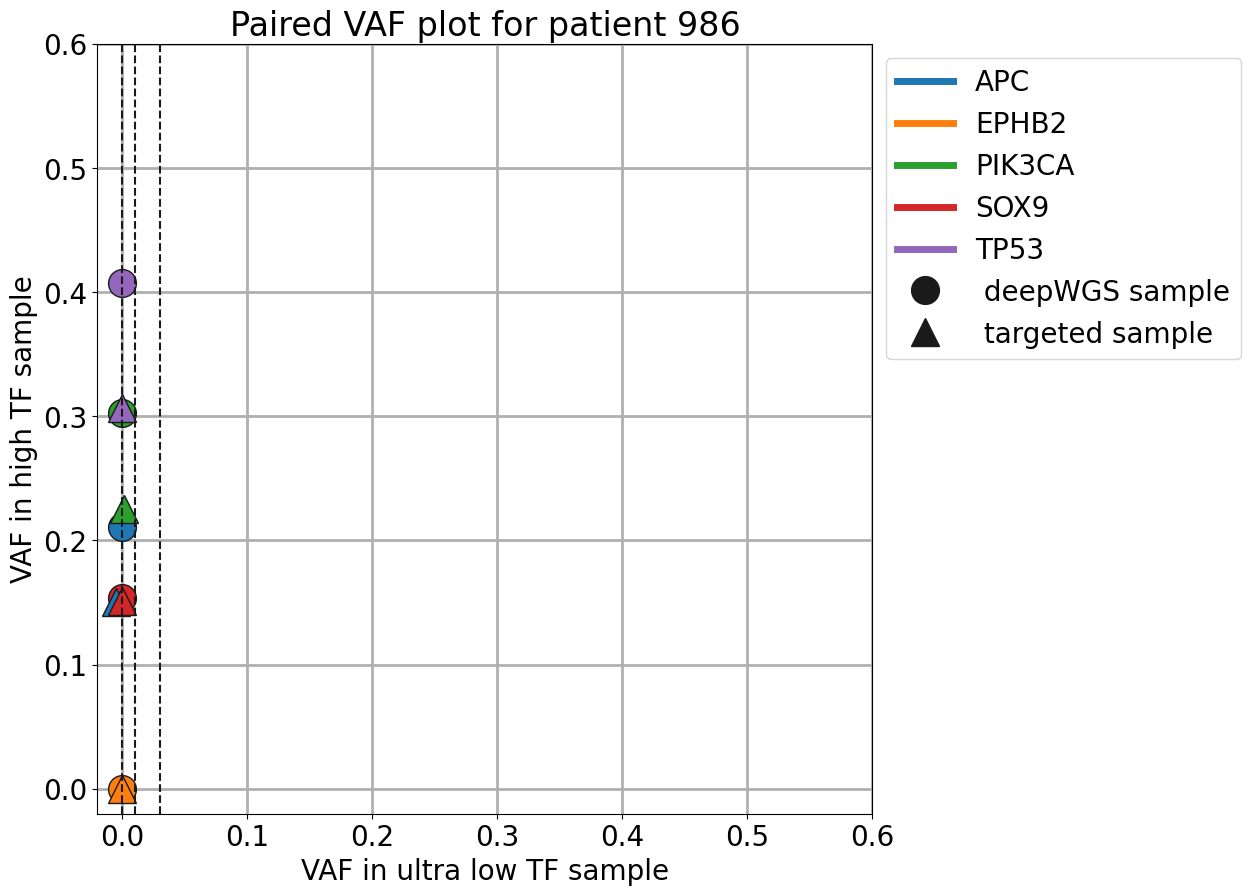

deepWGS
0
0.018691588785046728
targeted
0
0.03301491536785654


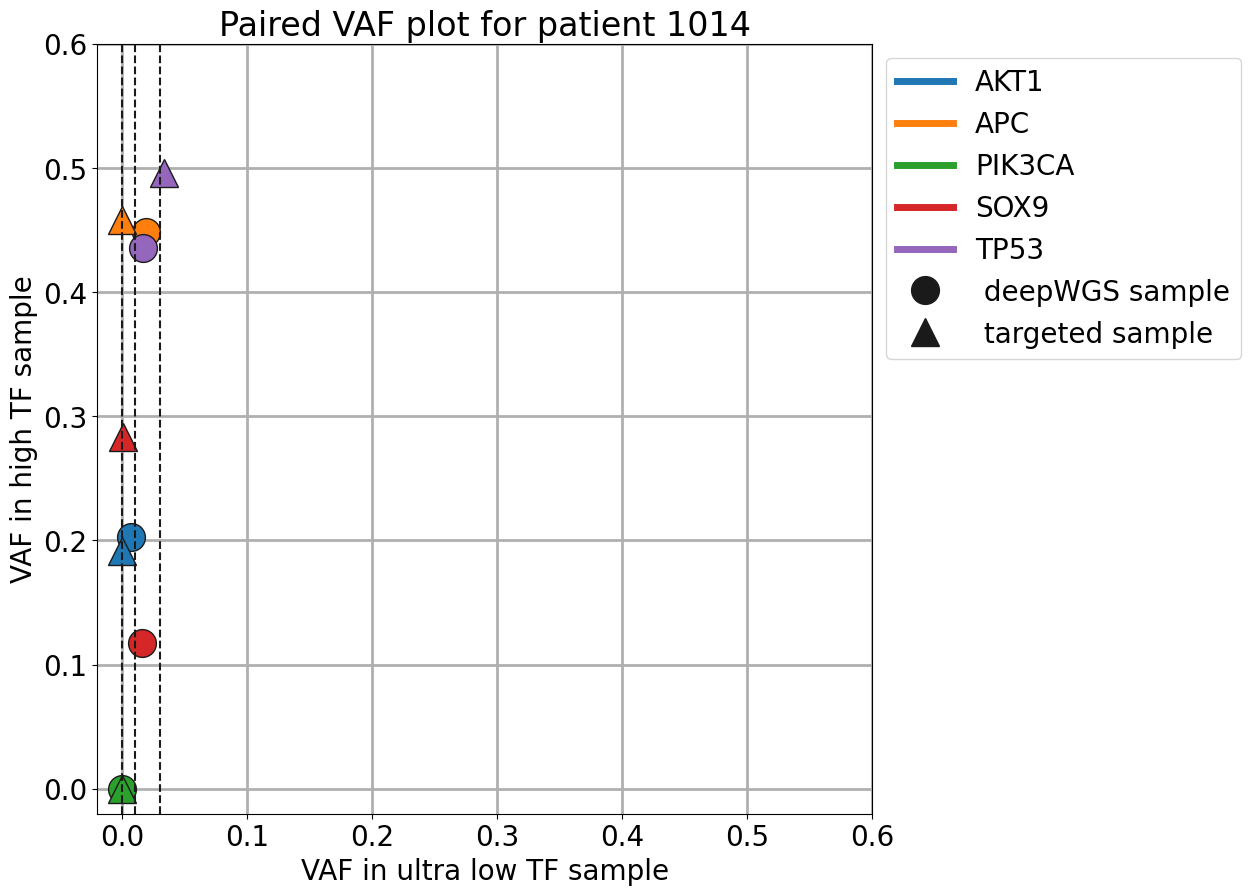

deepWGS
0
0.04081632653061224
targeted
0
0.04081632653061224


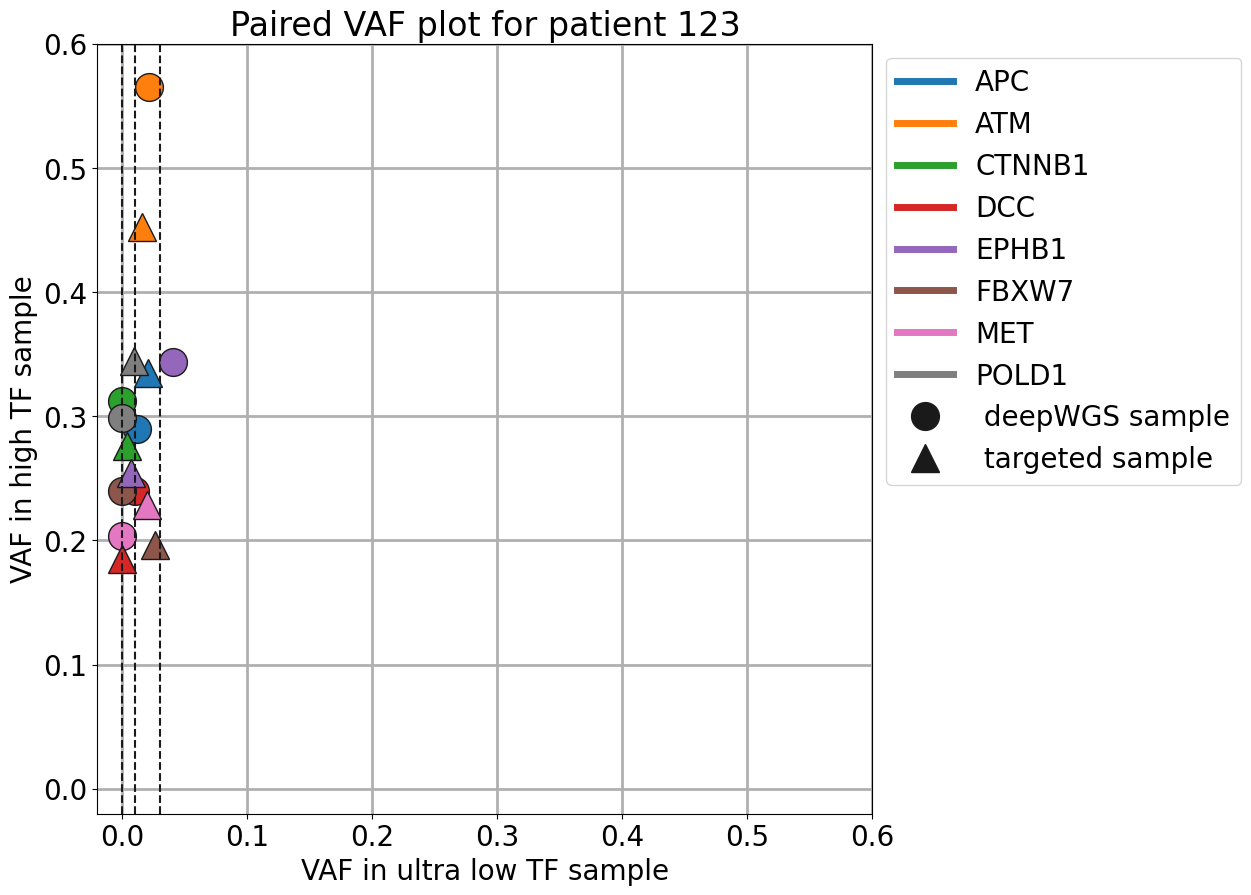

In [145]:

markers= ['o', '^']
alphas = [1, 0.5]
fillstyles=['full', 'none']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey']

for patient in ['986', '1014', '123']:

    plt.figure(figsize=(10,10))
    plt.grid()

    maxx = 0
    for si, seqtype in enumerate([ 'deepWGS', 'targeted']):

        mutationfile = pd.read_excel(os.path.join(*config.mutationfolder, [f for f in os.listdir(os.path.join(*config.mutationfolder)) if f.startswith('CCG_226_'+patient)][0]))
        mutationfile['chrom_pos'] = mutationfile['#CHROM'].astype('str').str.cat(mutationfile['POS'].astype('str'), sep="_")
        mutationfile.set_index('chrom_pos', inplace=True)
        mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
        for c in list(mutationfile.columns[13:-1]):
            if (sum([p.split('-')[1].split('_')[1] in c for p in patientsample_dict[patient]]) == 0) and (c != 'CCG_226_986.110215.P'):
                mutationfile.drop(c, axis=1, inplace=True)
        ctokeep = [c for c in mutationfile.columns if c.startswith('CCG') or c.startswith(patient)]
        mutationfile[mutationfile['TIERS'] == 'Trusted'][['REF', 'ALT', 'GENE', *ctokeep]]

        print(seqtype)
        lowtfsample_vaf_df = pd.read_csv(os.path.join(*config.lowtfsamplesfolder, 'targeted', patientsample_dict[patient][2] + '_' + seqtype + '_vaf.txt'), index_col=0)
        lowtfsample_vaf_df['chrom_pos'] = lowtfsample_vaf_df['chrom'].astype('str').str.cat(lowtfsample_vaf_df['pos'].astype('str'), sep="_")
        lowtfsample_vaf_df.set_index('chrom_pos', inplace=True)
        lowtfsample_vaf_df = lowtfsample_vaf_df.loc[~lowtfsample_vaf_df.index.duplicated()]
        lowtfsample_vaf_df['annotation'] = 'No annotation'
        if seqtype == 'deepWGS':
            mutationfile.reset_index(inplace=True)
            for i in range(mutationfile.shape[0]):
                if mutationfile['chrom_pos'].iloc[i] in targetbedhg38list:
                    val = targetbedhg19list[targetbedhg38list.index(mutationfile['chrom_pos'].iloc[i])]
                    mutationfile.iat[i, 0] = val
                else:
                    mutationfile.iloc[i]['chrom_pos'] = np.nan
            mutationfile['chrom_pos'] = mutationfile['chrom_pos'].apply(lambda x: x.split('_')[0][:3] + '_' + x.split('_')[1]) ###
            mutationfile.set_index('chrom_pos', inplace=True)
            mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
        mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
        lowtfsample_vaf_df.loc[list(set(mutationfile.index) & set(lowtfsample_vaf_df.index)), 'annotation'] = mutationfile['TIERS']
        lowtfsample_vaf_df = lowtfsample_vaf_df[lowtfsample_vaf_df['annotation'] == 'Trusted'] #  != 'No annotation'
        lowtfsample_vaf_df['gene'] = mutationfile.loc[lowtfsample_vaf_df.index, 'GENE']
        lowtfsample_vaf_df['ref'] = mutationfile.loc[lowtfsample_vaf_df.index, 'REF']
        lowtfsample_vaf_df['alt'] = mutationfile.loc[lowtfsample_vaf_df.index, 'ALT']
        lowtfsample_vaf_df['pileup'].fillna('', inplace=True)
        lowtfsample_vaf_df['pileup'] = lowtfsample_vaf_df['pileup'].astype(str)
        lowtfsample_vaf_df['supporting altcov'] = lowtfsample_vaf_df[['pileup', 'alt', 'ref']].apply(lambda x: x[0].count(x[1]) if (len(x[1]) == 1) and (len(x[2]) == 1) else x[0].count('+'+str(len(x[1][1:]))+x[1][1:]) if len(x[1]) > 1 else x[0].count('-'+str(len(x[2][1:]))+x[2][1:]), axis=1)
        lowtfsample_vaf_df['supporting vaf'] = lowtfsample_vaf_df['supporting altcov']/lowtfsample_vaf_df['totcov']
        for pi in range(1):
            print(pi)
            hightfsample_vaf_df = pd.read_csv(os.path.join(*config.lowtfsamplesfolder, 'targeted', patientsample_dict[patient][pi] + '_' + seqtype + '_vaf.txt'), index_col=0)
            hightfsample_vaf_df['chrom_pos'] = hightfsample_vaf_df['chrom'].astype('str').str.cat(hightfsample_vaf_df['pos'].astype('str'), sep="_")
            hightfsample_vaf_df.set_index('chrom_pos', inplace=True)
            hightfsample_vaf_df = hightfsample_vaf_df.loc[~hightfsample_vaf_df.index.duplicated()]
            hightfsample_vaf_df['annotation'] = 'No annotation'
            if seqtype == 'deepWGS':
                mutationfile.reset_index(inplace=True)
                for i in range(mutationfile.shape[0]):
                    if mutationfile['chrom_pos'].iloc[i] in targetbedhg38list:
                        val = targetbedhg19list[targetbedhg38list.index(mutationfile['chrom_pos'].iloc[i])]
                        mutationfile.iat[i, 0] = val
                    else:
                        mutationfile.iloc[i]['chrom_pos'] = np.nan
                # mutationfile['chrom_pos'].apply(lambda x: targetbedhg19list[targetbedhg38list.index(x)])
                mutationfile['chrom_pos'] = mutationfile['chrom_pos'].apply(lambda x: x.split('_')[0][:3] + '_' + x.split('_')[1]) ###
                mutationfile.set_index('chrom_pos', inplace=True)
                mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
            mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
            hightfsample_vaf_df.loc[list(set(mutationfile.index) & set(hightfsample_vaf_df.index)), 'annotation'] = mutationfile['TIERS']
            hightfsample_vaf_df = hightfsample_vaf_df[hightfsample_vaf_df['annotation'] == 'Trusted'] #  != 'No annotation'
            hightfsample_vaf_df['gene'] = mutationfile.loc[hightfsample_vaf_df.index, 'GENE']
            hightfsample_vaf_df['ref'] = mutationfile.loc[hightfsample_vaf_df.index, 'REF']
            hightfsample_vaf_df['alt'] = mutationfile.loc[hightfsample_vaf_df.index, 'ALT']
            hightfsample_vaf_df['pileup'].fillna('', inplace=True)
            hightfsample_vaf_df['pileup'] = hightfsample_vaf_df['pileup'].astype(str)
            hightfsample_vaf_df['supporting altcov'] = hightfsample_vaf_df[['pileup', 'alt', 'ref']].apply(lambda x: x[0].count(x[1]) if (len(x[1]) == 1) and (len(x[2]) == 1) else x[0].count('+'+str(len(x[1][1:]))+x[1][1:]) if len(x[1]) > 1 else x[0].count('-'+str(len(x[2][1:]))+x[2][1:]), axis=1)
            hightfsample_vaf_df['supporting vaf'] = hightfsample_vaf_df['supporting altcov']/hightfsample_vaf_df['totcov']

            paired_vaf = pd.concat([lowtfsample_vaf_df[lowtfsample_vaf_df['annotation'] == 'Trusted'][['supporting vaf']],
                                    hightfsample_vaf_df[hightfsample_vaf_df['annotation'] == 'Trusted'][['supporting vaf']]], axis=1)
            paired_vaf.columns = [patientsample_dict[patient][2].split('-')[1], patientsample_dict[patient][pi].split('-')[1]]
            maxx = paired_vaf[patientsample_dict[patient][2].split('-')[1]].max() if paired_vaf[patientsample_dict[patient][2].split('-')[1]].max() > maxx else maxx
            print(maxx)
            paired_vaf['gene'] = mutationfile.loc[paired_vaf.index, 'GENE']
            if patient == '986' and seqtype == 'targeted':
                paired_vaf.iat[0,0] = -0.005 # (intead of 0 for APC, for visualisation
            for gi, g in enumerate(list(paired_vaf['gene'])):
                plt.plot(paired_vaf[paired_vaf['gene'] == g][patientsample_dict[patient][2].split('-')[1]].values[0],
                         paired_vaf[paired_vaf['gene'] == g][patientsample_dict[patient][pi].split('-')[1]].values[0], lw=5, markeredgewidth=1,
                         c=colors[gi], markersize=20, marker=markers[si], fillstyle=fillstyles[0], markeredgecolor='k', label=g + '*' + ' ' + seqtype + ' sample')
                         #c=colors[gi], markersize=20, marker=markers[pi], alpha=alphas[si], label=g + '*' + 'high TF sample '+patientsample_dict[patient][pi].split('-')[1])

    #plt.xlim([-0.002, max(0.05,round(maxx+0.01, 2))])
    plt.ylim([-.02, 0.6])
    plt.xlim([-.02, 0.6])
    #plt.plot([0,1], [0,1], ls='--', c='k')
    plt.axvline(x=0.000, ls='--', c='k')
    plt.axvline(x=0.01, ls='--', c='k')
    plt.axvline(x=0.03, ls='--', c='k')
    plt.title('Paired VAF plot for patient ' +patient)
    ax = plt.gca()
    hand, labl = ax.get_legend_handles_labels()
    hand, labl = function_to_split(hand, labl, '*')
    ax.legend(hand, labl, bbox_to_anchor=(1, 1), loc="upper left")
    plt.xlabel('VAF in ultra low TF sample')
    plt.ylabel('VAF in high TF sample')
    plt.savefig(os.path.join(*config.outputpath, 'lowtbsamples', 'check', 'pairedplot_vaf_trusted_'+patient+'_samescale.svg'), bbox_inches='tight')
    plt.show()